In [384]:
import shapely
from shapely.geometry import LinearRing, LineString, Point
from numpy import sin, cos, pi, sqrt
from random import random

import numpy as np
from matplotlib import pyplot as plt

# Constants

In [385]:
# arena measurements

R = 0.021  # radius of wheels in meters
L = 0.094  # distance between wheels in meters

W = 1.18  # width of arena
H = 1.94  # height of arena
margin = 0.05 # offset position of robot from wall

# floor/ceil coordinates for particle distribution
x_floor = -W/2 + margin
x_ceil = W/2 - margin
y_floor = -H/2 + margin
y_ceil = H/2 - margin

# range for particle distribution
range_x = W - 2 * margin
range_y = H - 2 * margin

# the world is a rectangular arena with width W and height H
world = LinearRing([(W/2,H/2),(-W/2,H/2),(-W/2,-H/2),(W/2,-H/2)])

### This is the color coding for camera detection output:

    0   => nothing
    1   => red
    1.5 => red/green 
    2   => green
    2.5 => green/blue
    3   => blue
    3.5 => blue/yellow
    4   => yellow
    4.5 => yellow/red

# Functions

In [386]:
# converts degrees to radians
def dtr(deg):
    return deg * (np.pi / 180)

In [387]:
# this function simulates our camera by returning an integer representing the combination of corners
# that are currently visible in the view field of the camera

def simulateCamera(x, y, q):
    
    # two lines drawn with shapely
    camera_fov_left = LineString([(x, y), (x+cos(q-dtr(62.2))*2*W,(y+sin(q-dtr(62.2))*2*H)) ])
    camera_fov_right = LineString([(x, y), (x+cos(q+dtr(62.2))*2*W,(y+sin(q+dtr(62.2))*2*H)) ])
    
    # array of camera rays
    camera_rays = [camera_fov_left, camera_fov_right]

    # these constants represent the x/y coords of our maps walls
    left_x = -(W/2)
    right_x = W/2
    top_y = H/2
    bot_y = -(H/2)
    
    detected = []
    
    # loop over the two rays (left and right border of field-of-view)
    for ray in camera_rays:
        s = world.intersection(ray)
        
        # Going clockwise starting with top wall == case 1
        # we have 8 cases of hitting one of the four walls or one of the corners four directly.
        
        
        # top right corner
        if s.x == right_x and s.y == top_y:
            detected.append(2)
        # bot right corner
        elif s.x == right_x and s.y == bot_y:
            detected.append(4)
        # bot left corner
        elif s.x == left_x and s.y == bot_y:
            detected.append(6)
        # top left corner
        elif s.x == left_x and s.y == top_y:
            detected.append(8)      
        # top wall
        elif s.y == top_y:
            detected.append(1)
        # right wall
        elif s.x == right_x:
            detected.append(3)
        # bot wall
        elif s.y == bot_y:
            detected.append(5)
        # left wall
        elif s.x == left_x:
            detected.append(7)
        
    
    # hacky trick: we use a tuple here to be able to do array comparison
    # note: the order matters, detect[0] = left border, detect[1] = right border
    detect = (detected[0], detected[1])
    
    if detect == (1,1) or detect == (3,3) or detect == (5,5) or detect == (7,7):
        return 0
    elif detect == (1,2) or detect == (1,3) or detect == (2,3):
        return 1
    elif detect == (1,5):
        return 1.5
    elif detect == (3,4) or detect == (3,5) or detect == (4,5):
        return 2
    elif detect == (3,7):
        return 2.5
    elif detect == (5,6) or detect == (5,7) or detect == (6,7):
        return 3
    elif detect == (5,1):
        return 3.5
    elif detect == (7,8) or detect == (7,1) or detect == (8,1):
        return 4
    elif detect == (7,3):
        return 4.5
    else:
        return None # just an error catch case, should not happen

In [388]:
# this function returns a normal distributed array of view angles (q), based on camera input
# the reason why "right" is q = 0, is because Casper's simulation was built that way
# IMPORTANT: only call this function, when camera_int != 0. The camera has to report something, otherwise spin robot until it does.

def distributeViewAngles(camera_int):
    view_angle = 360 # this is the direction where the robot camera and lidar[0] are facing => 360 >> right (default)
    spread = 10 # this is the std. deviation 
    
    # case red >> top right corner
    if camera_int == 1:
        view_angle = 315

    # case red/green >> right
    if camera_int == 1.5:
        view_angle = 360
    
    # case green >> bottom right corner
    if camera_int == 2:
        view_angle = 45
        
    # case green/blue >> bottom
    if camera_int == 2.5:
        view_angle = 90

    # case blue >> bottom left corner
    if camera_int == 3:
        view_angle = 135
    
    # case blue/yellow >> left
    if camera_int == 3.5:
        view_angle = 180
        
    # case yellow >> top left corner
    if camera_int == 4:
        view_angle = 225
        
    # case yellow/red >> top
    if camera_int == 4.5:
        view_angle = 270
        
    return dtr(np.clip(np.random.normal(view_angle, spread, (100, 1)), a_min=0, a_max=None))

In [389]:
# this function does the initial particle placement, random spread across the whole map (minus a small margin)
# calls distributeViewAngles for normal distribution of q

def placeParticles(camera_int):
    start_x = x_floor
    start_y = y_ceil
    
    random_values = np.random.rand(100, 2)
    
    calc_pos_x = np.vectorize(lambda x: start_x + range_x * x)
    calc_pos_y = np.vectorize(lambda y: start_y - range_y * y)
    
    x_col = calc_pos_x(random_values[:,:1])
    y_col = calc_pos_y(random_values[:,1:2])
    
    q_col = distributeViewAngles(camera_int)

    particles = np.concatenate((x_col, y_col, q_col), axis=1)
    return particles

In [390]:
# this function returns a normal distributed array of particles based on the previous location approximation

def resampleParticles(x, y, camera_int):
    x_col = np.clip(np.random.normal(x, 0.1, (100, 1)), x_floor, x_ceil)
    y_col = np.clip(np.random.normal(y, 0.1, (100, 1)), y_floor, y_ceil)
    
    q_col = distributeViewAngles(camera_int)
    
    return np.concatenate((x_col, y_col, q_col), axis=1)

In [391]:
# this utility functions allows application of simulateParticleLidar() to a matrix, using matrix operations
# it is a wrapper function for simulateParticleLidar()
# takes an array [x, y, q] as input

def rollLinewise(vector):
    rangeMat = np.arange(8).reshape((8,1))
    
    laserMat = np.array([vector,]*8)
    
    joinMat = np.concatenate((laserMat, rangeMat), axis=1)
    
    return np.apply_along_axis(simulateParticleLidar, 1, joinMat)

In [392]:
# this function returns an array of 8 lidar measurements with a step of 45 degrees
# takes a matrix of [[x, y, q, i], ... ] as input, where i is a multiplicator for 45 degrees

def simulateParticleLidar(mat):
    line = LineString([(mat[0], mat[1]), (mat[0]+cos(mat[2]+dtr(mat[3]*45))*2*W,(mat[1]+sin(mat[2]+dtr(mat[3]*45))*2*H))])
    s = world.intersection(line)
    distance = sqrt((s.x-mat[0])**2+(s.y-mat[1])**2)
    
    return distance

In [393]:
# this function returns the index of lidar measurement with the lowest delta (sum across all angles)

def getFittestIndex(robot_lidar, particles_lidar):
    delta = np.absolute(particles_lidar - robot_lidar)
    sum_delta = np.apply_along_axis(np.sum, 1, delta)
    return np.argmin(sum_delta)

### Testing lidar and particle simulator

In [337]:
particles = placeParticles(3)
print(particles)

[[-3.27927466e-01 -8.90719316e-01  2.37947371e+00]
 [-2.34408772e-01  1.84385610e-01  2.27424889e+00]
 [ 7.11779353e-02 -1.26358574e-01  2.29190562e+00]
 [ 1.43551640e-01 -6.01334904e-01  2.35394448e+00]
 [-4.88091563e-01 -6.13890489e-01  2.30229356e+00]
 [ 9.92144457e-02 -7.64903314e-01  2.26666107e+00]
 [-3.98140468e-01 -6.57172604e-01  2.51626842e+00]
 [ 1.95495886e-02 -6.96838335e-02  2.48347927e+00]
 [-8.95760541e-02 -3.09569351e-01  2.27006318e+00]
 [ 4.58779251e-01 -4.38735668e-01  2.30799488e+00]
 [ 2.18461885e-01 -1.79704671e-01  2.23177732e+00]
 [ 4.57601145e-01  9.02254943e-01  2.20649505e+00]
 [-4.28932615e-01 -3.07604697e-01  2.40241241e+00]
 [-4.80181116e-01 -1.11869947e-01  2.30540850e+00]
 [-8.99772747e-02  6.46701931e-01  2.07826597e+00]
 [ 4.39891878e-02  4.80091168e-01  2.38579451e+00]
 [ 6.13741585e-02 -6.81116022e-01  2.55625992e+00]
 [ 1.27818636e-01 -9.13148165e-01  2.55276599e+00]
 [ 1.87853182e-01  8.94424849e-01  2.40459872e+00]
 [-4.06510959e-02 -2.06387201e-

In [338]:
print(particles[:1, :])

[[-0.32792747 -0.89071932  2.37947371]]


In [ ]:
distances = np.apply_along_axis(rollLinewise, 1, particles)
# print(distances)

In [218]:
# data = placeParticles()
data = resampleParticles(0.45,0.5)
# print(data)

In [235]:
robot = [0.20787156, 0.31878178, 0.44155375, 1.32133476, 1.77038155, 1.02934888, 0.4293922, 0.21328546]
delta = getFittestIndex(distances, robot)
print(delta.min())

13


In [371]:
a = particles[13]
print(a[0])

-0.48018111589788753


In [361]:
b = particles[13] < 0
print(b)

[ True  True False]


In [364]:
c = np.where(b == True)
print(c[0][0])

0


In [365]:
a[c]

array([-0.48018112, -0.11186995])

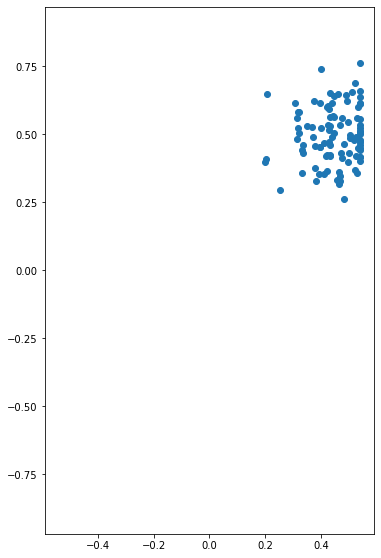

In [219]:
f, ax = plt.subplots(1,1, figsize=(W*5,H*5))
ax.set_xlim(-W/2, W/2)
ax.set_ylim(-H/2, H/2)

ax.scatter(data[:,0], data[:,1])


# When the robot senses an obstacle, draw the sensor that detects it.
# obstacled = data[data[:,4] == 1]
# ax.quiver(obstacled[:,0], obstacled[:,1], obstacled[:,5], obstacled[:,6], color='red',alpha=0.5)


plt.show()

## Simulation

In [412]:
# Constants simulation

robot_timestep = 0.1        # 1/robot_timestep equals update frequency of robot
simulation_timestep = 0.01  # timestep in kinematics sim (probably don't touch..)

# Variables robot
###########

x = 0   # robot position in meters - x direction - positive to the right 
y = 0   # robot position in meters - y direction - positive up
q = 0.0   # robot heading with respect to x-axis in radians

left_wheel_velocity =  random()   # robot left wheel velocity in radians/s
right_wheel_velocity =  random()  # robot right wheel velocity in radians/s

# Sensor measurements
##################

# central sensor: robot starts 80mm in front 0.008
# side sensors: robot starts 78mm in front 0.0078

# Kinematic model
#################
# updates robot position and heading based on velocity of wheels and the elapsed time
# the equations are a forward kinematic model of a two-wheeled robot - don't worry just use it
def simulationstep():
    global x, y, q
    
    for step in range(int(robot_timestep/simulation_timestep)):     #step model time/timestep times
        v_x = cos(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2) 
        v_y = sin(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2)
        omega = (R*right_wheel_velocity - R*left_wheel_velocity)/(2*L)    
    
        x += v_x * simulation_timestep
        y += v_y * simulation_timestep
        q += omega * simulation_timestep

# Simulation loop
#################
file = open("trajectory.dat", "w")
file2 = open("approximate.dat", "w")

for cnt in range(10000):
    
    robot = np.array([x, y, q])
    
    # this array contains the distances to the walls, simulating our lidar laser range finder's output
    robot_lidar = rollLinewise(robot)
    
    # making sure that our robot does not go closer to the walls than the indicated margin
    min_distance = margin
    
    # TO-DO
    # check, if a value in the distances array is below the threshold
    # get the index of it to map onto angle (45,90,135, etc.)
    
    # array of boolans
    is_below_threshold = robot_lidar < min_distance
    
    # robot control here
    if np.any(is_below_threshold):
        
        # first index of lidar, where distance < threshold
        lidar_index = np.where(is_below_threshold == True)[0][0]

        # if we hit a lidar on the right [i <= 3], we go left! if we hit a lidar on the left [i > 3], we go right!
        # goes left when hit straight and right, when hit in the back (virtually never occurs)
        
        if lidar_index <= 3: # obstacle to the right. turn left
            left_wheel_velocity = 0.4 
            right_wheel_velocity = -0.4
            
        if lidar_index > 3: # Obstacle to left. turn right
            left_wheel_velocity = -0.4
            right_wheel_velocity = 0.4
        
    else:
        if cnt%100==0:
            speed = random()
        
            left_wheel_velocity = speed
            right_wheel_velocity = speed
        
    #step simulation
    simulationstep()

    #check collision with arena walls 
    if (world.distance(Point(x,y))<L/2):
        break
        
    if cnt%50==0:
        
        # integer between 0 and 4.5
        camera_output = simulateCamera(x, y, q)
        
        # format [[x, y, q], ...]
        particles = placeParticles(camera_output)
        
        # this array contains the distances to the walls, simulating our lidar laser range finder's output
        particles_lidar = np.apply_along_axis(rollLinewise, 1, particles)
        
        # location approximation [x, y, q]
        approx = particles[getFittestIndex(robot_lidar, particles_lidar)]
        
        # ATTN: CHANGE LAST TWO VALUES IF WE MOVE UP TO FIVE SENSORS. CODE WILL NOT WORK
        file.write( str(x) + ", " + str(y) + ", " + str(cos(q)*0.05) + ", " + str(sin(q)*0.05) + "\n")
        file2.write( str(approx[0]) + ", " + str(approx[1]) + ", " + str(cos(approx[2])*0.05) + ", " + str(sin(approx[2])*0.05) + "\n")

file.close()
file2.close()

## Plotting

In [413]:
# load data from file into numpy
data = np.loadtxt("trajectory.dat", delimiter=", ")
data2 = np.loadtxt("approximate.dat", delimiter=", ")

In [414]:
def plotTrajectory(data):
    f, ax = plt.subplots(1,1, figsize=(W*5,H*5))
    ax.set_xlim(-W/2, W/2)
    ax.set_ylim(-H/2, H/2)
    
    ax.quiver(data[:,0], data[:,1], data[:,2], data[:,3])
    
    plt.show()   

In [419]:
def plotTrajectoryByIndex(data, data2, i, end=1):
    j = i + end # optional parameter to plot a slice of the array (or just one row by default)
    
    f, ax = plt.subplots(1,1, figsize=(W*5,H*5))
    ax.set_xlim(-W/2, W/2)
    ax.set_ylim(-H/2, H/2)
    
    ax.quiver(data[i:j,0], data[i:j,1], data[i:j,2], data[i:j,3])
    ax.quiver(data2[i:j,0], data2[i:j,1], data2[i:j,2], data2[i:j,3])
    
    plt.show()  

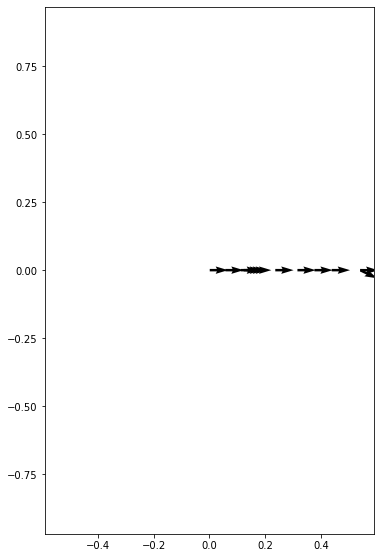

In [420]:
plotTrajectory(data)

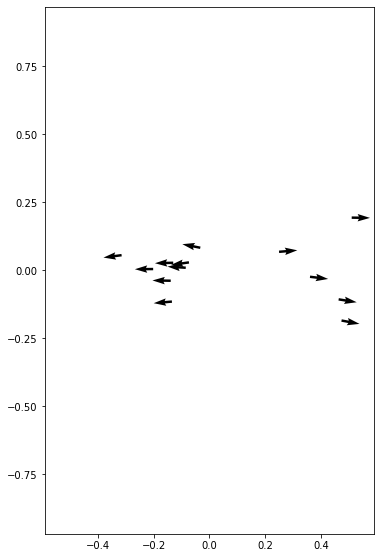

In [421]:
plotTrajectory(data2)

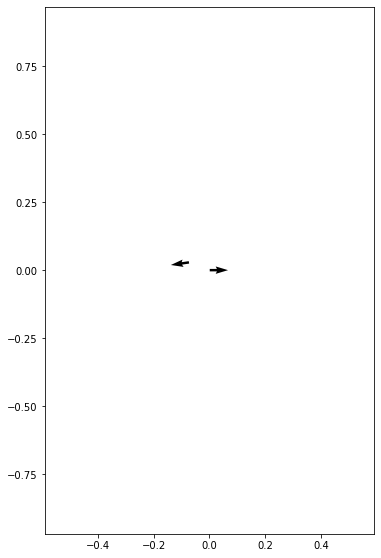

In [422]:
plotTrajectoryByIndex(data, data2, 0)